### Finetuning Codebase

> The code for training of the baseline model is present at main.ipynb, this file contains the finetuning process of those models.

#### Two Step Finetuning Process
1. Fine-Tuning
    - Setup: Unfreeze the top layers of the base model and train with a low learning rate.
    - Goal: To isolate and measure the performance gain from fine-tuning alone.

2. Fine-Tuning + Class Weighting
    - Setup: Take the fine-tuned model and add class weights during training.
    - Goal: The difference in performance between this and Exp. 2 will show the exact contribution of handling class imbalance.

1st Step Finetuning of mobilenetv2

Model configured for fine-tuning. Trainable layers: 34


Model: "functional_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_5 (InputLayer)      │ (None, 224, 224, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ mobilenetv2_1.00_224            │ (None, 7, 7, 1280)     │     2,257,984 │
│ (Functional)                    │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d_2      │ (None, 1280)           │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ (None, 1280)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 5)              │         6,405 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 2,264,389 (8.64 MB)

 Trainable params: 1,532,805 (5.85 MB)

 Non-trainable params: 731,584 (2.79 MB)


Starting mobilenetv2_finetuned model training...
Epoch 1/100
40/40 ━━━━━━━━━━━━━━━━━━━━ 18s 299ms/step - accuracy: 0.1506 - loss: 2.2143 - val_accuracy: 0.3425 - val_loss: 1.5380
Epoch 2/100
40/40 ━━━━━━━━━━━━━━━━━━━━ 10s 259ms/step - accuracy: 0.3344 - loss: 1.6808 - val_accuracy: 0.4365 - val_loss: 1.3159
Epoch 3/100
40/40 ━━━━━━━━━━━━━━━━━━━━ 10s 255ms/step - accuracy: 0.4616 - loss: 1.3960 - val_accuracy: 0.4862 - val_loss: 1.1801
Epoch 4/100
40/40 ━━━━━━━━━━━━━━━━━━━━ 11s 264ms/step - accuracy: 0.5605 - loss: 1.1522 - val_accuracy: 0.5801 - val_loss: 1.0911
Epoch 5/100
40/40 ━━━━━━━━━━━━━━━━━━━━ 11s 265ms/step - accuracy: 0.6495 - loss: 0.9495 - val_accuracy: 0.6133 - val_loss: 1.0322
Epoch 6/100
40/40 ━━━━━━━━━━━━━━━━━━━━ 10s 261ms/step - accuracy: 0.7088 - loss: 0.8529 - val_accuracy: 0.6519 - val_loss: 0.9837
Epoch 7/100
40/40 ━━━━━━━━━━━━━━━━━━━━ 11s 265ms/step - accuracy: 0.7617 - loss: 0.7210 - val_accuracy: 0.6740 - val_loss: 0.9483
Epoch 8/100
40/40 ━━━━━━━━━━━━━━━━━━━━ 1

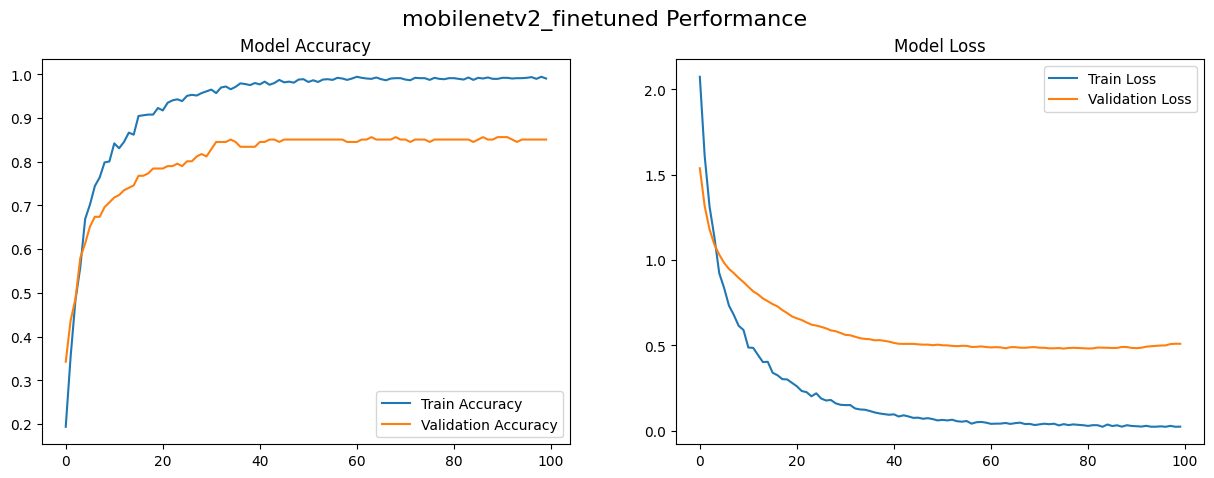


--- mobilenetv2_finetuned In-Depth Model Evaluation ---
12/12 ━━━━━━━━━━━━━━━━━━━━ 4s 251ms/step

Classification Report:

                        precision    recall  f1-score   support

Brinjal Fruit Creaking       0.83      0.85      0.84        40
        Healty Brinjal       0.93      0.96      0.94       103
      Phomopsis Bright       0.79      0.72      0.75        32
 Shoot and Fruit Borer       0.92      0.91      0.92       145
               Wet Rot       0.85      0.85      0.85        41

              accuracy                           0.89       361
             macro avg       0.86      0.86      0.86       361
          weighted avg       0.89      0.89      0.89       361

Classification report saved to results\mobilenetv2_finetuned\classification_report.csv


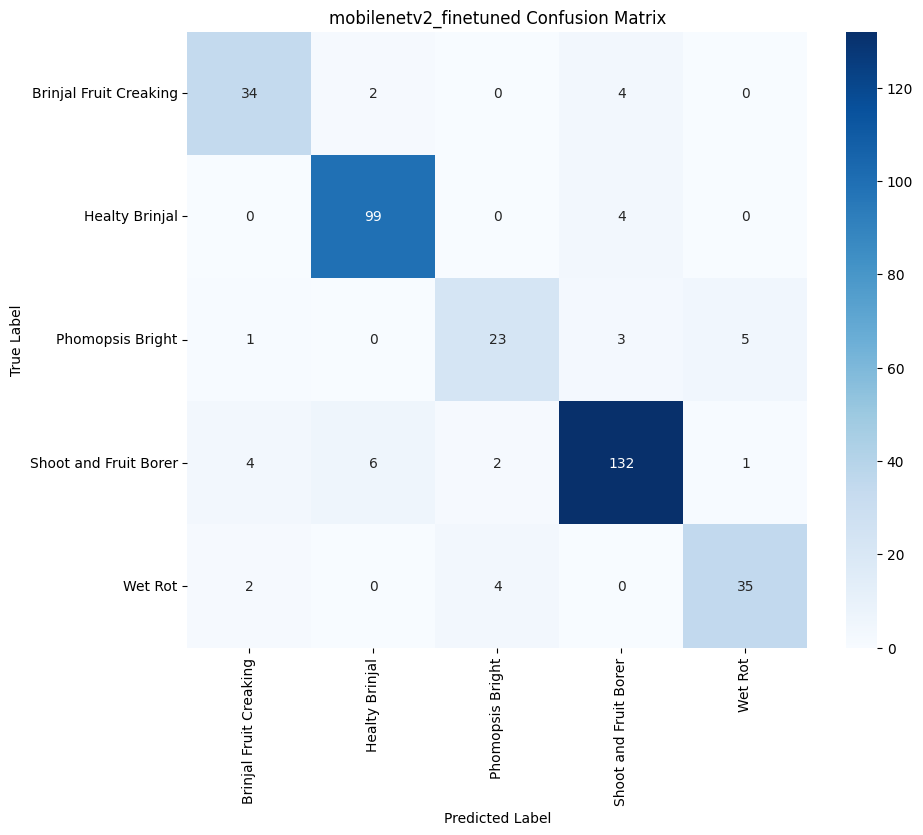


Updating summary results file...
Updated results for mobilenetv2_finetuned in results\summary_results.csv

Finetuned mobilenetv2_finetuned model saved to 'models/mobilenetv2_finetuned.keras'


In [3]:
import os
import numpy as np
import json
import matplotlib.pyplot as plt
import pandas as pd
import tensorflow as tf
from tensorflow.keras import layers, models
from tensorflow.keras.applications import MobileNetV2
from tensorflow.keras.optimizers import Adam

# --- 1. Configuration and Setup ---
PROCESSED_DIR = os.path.join('processed_data', 'BrinjalFruitX')
RESULTS_DIR = 'results'
# IMPORTANT: New model name for this experiment
MODEL_NAME = 'mobilenetv2_finetuned' 

model_results_dir = os.path.join(RESULTS_DIR, MODEL_NAME)
os.makedirs(model_results_dir, exist_ok=True)

# --- (Data loading code is the same) ---
X_train = np.load(os.path.join(PROCESSED_DIR, 'X_train.npy'))
y_train = np.load(os.path.join(PROCESSED_DIR, 'y_train.npy'))
X_val = np.load(os.path.join(PROCESSED_DIR, 'X_val.npy'))
y_val = np.load(os.path.join(PROCESSED_DIR, 'y_val.npy'))
X_test = np.load(os.path.join(PROCESSED_DIR, 'X_test.npy'))
y_test = np.load(os.path.join(PROCESSED_DIR, 'y_test.npy'))
with open(os.path.join(PROCESSED_DIR, 'class_names.json'), 'r') as f:
    class_names = json.load(f)

# --- 2. Define the Model for Fine-Tuning ---
base_model = MobileNetV2(input_shape=(224, 224, 3), include_top=False, weights='imagenet')

# Start with the base model frozen, just like before
base_model.trainable = False 

# Add our custom head
inputs = layers.Input(shape=(224, 224, 3))
x = base_model(inputs, training=False)
x = layers.GlobalAveragePooling2D()(x)
x = layers.Dropout(0.5)(x)
outputs = layers.Dense(len(class_names), activation='softmax')(x)
model = models.Model(inputs, outputs)

# We will unfreeze layers *after* compilation with the initial optimizer state
# Let's unfreeze the top 30 layers. MobileNetV2 has 154 layers.
fine_tune_at = len(base_model.layers) - 30 

base_model.trainable = True # Unfreeze the whole base model first
for layer in base_model.layers[:fine_tune_at]:
    layer.trainable = False # Then re-freeze all layers up to the fine-tuning point

# Compile the model with a VERY LOW learning rate
model.compile(
    optimizer=Adam(learning_rate=1e-5), # Critical for fine-tuning
    loss='sparse_categorical_crossentropy',
    metrics=['accuracy']
)

print(f"Model configured for fine-tuning. Trainable layers: {len(model.trainable_variables)}")
model.summary()


# --- 3. Train the Fine-Tuned Model ---
EPOCHS = 100 # Fine-tuning often benefits from more epochs
BATCH_SIZE = 32

print(f"\nStarting {MODEL_NAME} model training...")
history = model.fit(
    X_train, y_train,
    epochs=EPOCHS,
    batch_size=BATCH_SIZE,
    validation_data=(X_val, y_val)
)
print("Model training complete.")

# --- (The rest of the script for visualization and saving results is identical) ---
# --- 4. Visualize Performance and Save Figure ---
print("\nGenerating and saving performance plots...")
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 5))
fig.suptitle(f'{MODEL_NAME} Performance', fontsize=16)
ax1.plot(history.history['accuracy'], label='Train Accuracy')
ax1.plot(history.history['val_accuracy'], label='Validation Accuracy')
ax1.set_title('Model Accuracy')
ax1.legend(loc='lower right')
ax2.plot(history.history['loss'], label='Train Loss')
ax2.plot(history.history['val_loss'], label='Validation Loss')
ax2.set_title('Model Loss')
ax2.legend(loc='upper right')
plt.savefig(os.path.join(model_results_dir, 'accuracy_loss_plot.png'))
plt.show()

# --- 5. In-Depth Evaluation and Save Results ---
from sklearn.metrics import classification_report, confusion_matrix
import seaborn as sns

print(f"\n--- {MODEL_NAME} In-Depth Model Evaluation ---")
y_pred_probs = model.predict(X_test)
y_pred_classes = np.argmax(y_pred_probs, axis=1)

report_dict = classification_report(y_test, y_pred_classes, target_names=class_names, output_dict=True)
print("\nClassification Report:\n")
print(classification_report(y_test, y_pred_classes, target_names=class_names))

report_df = pd.DataFrame(report_dict).transpose()
report_df.to_csv(os.path.join(model_results_dir, 'classification_report.csv'))
print(f"Classification report saved to {os.path.join(model_results_dir, 'classification_report.csv')}")

cm = confusion_matrix(y_test, y_pred_classes)
plt.figure(figsize=(10, 8))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=class_names, yticklabels=class_names)
plt.title(f'{MODEL_NAME} Confusion Matrix')
plt.ylabel('True Label')
plt.xlabel('Predicted Label')
plt.savefig(os.path.join(model_results_dir, 'confusion_matrix.png'))
plt.show()

# --- 6. Update Summary Results File ---
print("\nUpdating summary results file...")
summary_file = os.path.join(RESULTS_DIR, 'summary_results.csv')
test_loss, test_accuracy = model.evaluate(X_test, y_test, verbose=0)

summary_data = {
    'model_name': MODEL_NAME,
    'test_accuracy': f"{test_accuracy:.4f}",
    'test_loss': f"{test_loss:.4f}",
    'macro_avg_f1-score': f"{report_dict['macro avg']['f1-score']:.4f}",
    'weighted_avg_f1-score': f"{report_dict['weighted avg']['f1-score']:.4f}"
}
new_results_df = pd.DataFrame([summary_data])

if os.path.exists(summary_file):
    summary_df = pd.read_csv(summary_file)
    if MODEL_NAME not in summary_df['model_name'].values:
        summary_df = pd.concat([summary_df, new_results_df], ignore_index=True)
    else: # If model name exists, update the row
        summary_df.loc[summary_df['model_name'] == MODEL_NAME] = new_results_df.values
    summary_df.to_csv(summary_file, index=False)
    print(f"Updated results for {MODEL_NAME} in {summary_file}")
else:
    new_results_df.to_csv(summary_file, index=False)
    print(f"Created new summary results file at {summary_file}")


# --- 7. Save the Trained Model ---
os.makedirs('models', exist_ok=True)
model.save(f'models/{MODEL_NAME}.keras')
print(f"\nFinetuned {MODEL_NAME} model saved to 'models/{MODEL_NAME}.keras'")

2nd Step Finetuning of mobilenetv2


Calculating class weights...
Class weights calculated:
{0: np.float64(1.8), 1: np.float64(0.7019498607242339), 2: np.float64(2.230088495575221), 3: np.float64(0.4970414201183432), 4: np.float64(1.7872340425531914)}

Starting mobilenetv2_finetuned_weighted model training...
Epoch 1/100
40/40 ━━━━━━━━━━━━━━━━━━━━ 20s 345ms/step - accuracy: 0.2158 - loss: 2.0827 - val_accuracy: 0.3149 - val_loss: 1.6040
Epoch 2/100
40/40 ━━━━━━━━━━━━━━━━━━━━ 12s 288ms/step - accuracy: 0.3314 - loss: 1.6567 - val_accuracy: 0.3702 - val_loss: 1.4646
Epoch 3/100
40/40 ━━━━━━━━━━━━━━━━━━━━ 12s 300ms/step - accuracy: 0.3947 - loss: 1.4899 - val_accuracy: 0.4199 - val_loss: 1.3591
Epoch 4/100
40/40 ━━━━━━━━━━━━━━━━━━━━ 12s 310ms/step - accuracy: 0.4953 - loss: 1.2404 - val_accuracy: 0.4696 - val_loss: 1.2700
Epoch 5/100
40/40 ━━━━━━━━━━━━━━━━━━━━ 12s 291ms/step - accuracy: 0.5640 - loss: 1.1675 - val_accuracy: 0.5138 - val_loss: 1.1885
Epoch 6/100
40/40 ━━━━━━━━━━━━━━━━━━━━ 12s 310ms/step - accuracy: 0.5984 - 

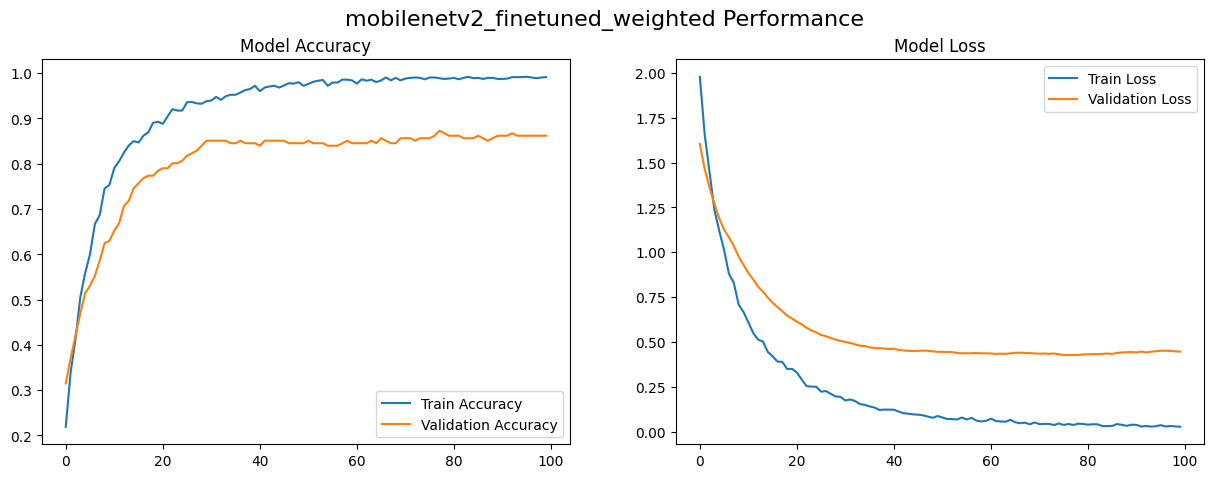


--- mobilenetv2_finetuned_weighted In-Depth Model Evaluation ---
12/12 ━━━━━━━━━━━━━━━━━━━━ 4s 279ms/step

Classification Report:

                        precision    recall  f1-score   support

Brinjal Fruit Creaking       0.83      0.85      0.84        40
        Healty Brinjal       0.93      0.96      0.95       103
      Phomopsis Bright       0.72      0.72      0.72        32
 Shoot and Fruit Borer       0.93      0.93      0.93       145
               Wet Rot       0.86      0.78      0.82        41

              accuracy                           0.89       361
             macro avg       0.86      0.85      0.85       361
          weighted avg       0.89      0.89      0.89       361

Classification report saved to results\mobilenetv2_finetuned_weighted\classification_report.csv


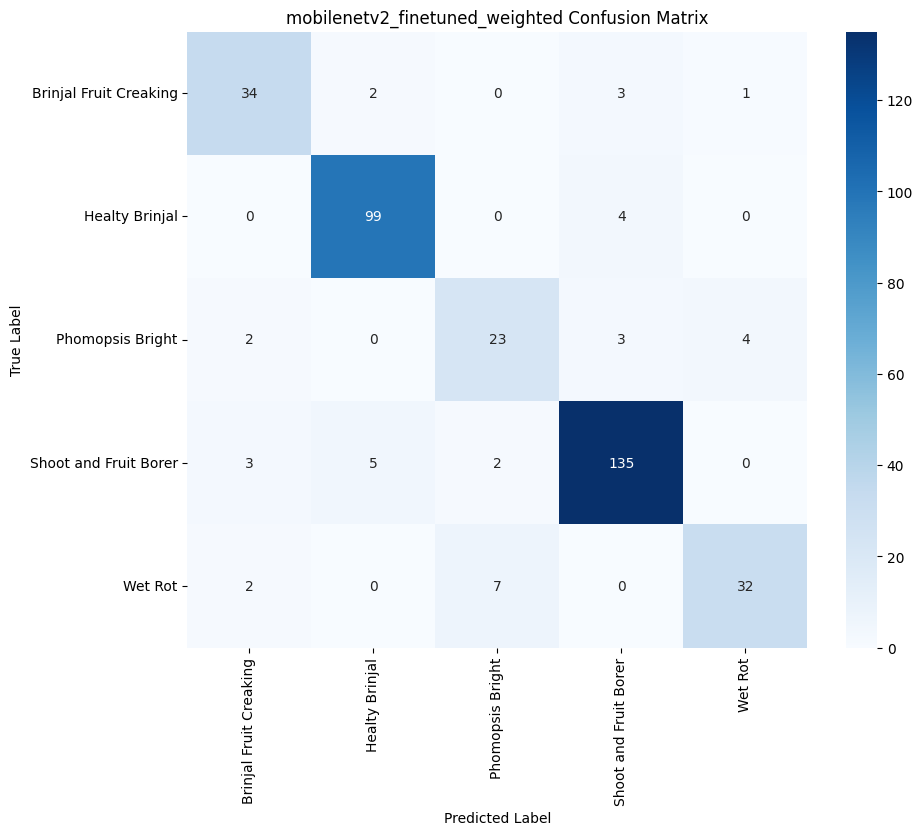


Updating summary results file...
Updated results for mobilenetv2_finetuned_weighted in results\summary_results.csv

Finetuned mobilenetv2_finetuned_weighted model saved to 'models/mobilenetv2_finetuned_weighted.keras'


In [4]:
import os
import numpy as np
import json
import matplotlib.pyplot as plt
import pandas as pd
import tensorflow as tf
from tensorflow.keras import layers, models
from tensorflow.keras.applications import MobileNetV2
from tensorflow.keras.optimizers import Adam
from sklearn.utils import class_weight # New import for calculating weights

# --- 1. Configuration and Setup ---
PROCESSED_DIR = os.path.join('processed_data', 'BrinjalFruitX')
RESULTS_DIR = 'results'
# IMPORTANT: New model name for this experiment
MODEL_NAME = 'mobilenetv2_finetuned_weighted' 

model_results_dir = os.path.join(RESULTS_DIR, MODEL_NAME)
os.makedirs(model_results_dir, exist_ok=True)

# --- (Data loading code is the same) ---
X_train = np.load(os.path.join(PROCESSED_DIR, 'X_train.npy'))
y_train = np.load(os.path.join(PROCESSED_DIR, 'y_train.npy'))
X_val = np.load(os.path.join(PROCESSED_DIR, 'X_val.npy'))
y_val = np.load(os.path.join(PROCESSED_DIR, 'y_val.npy'))
X_test = np.load(os.path.join(PROCESSED_DIR, 'X_test.npy'))
y_test = np.load(os.path.join(PROCESSED_DIR, 'y_test.npy'))
with open(os.path.join(PROCESSED_DIR, 'class_names.json'), 'r') as f:
    class_names = json.load(f)

# --- 2. Calculate Class Weights ---
# This is the new step to handle class imbalance
print("\nCalculating class weights...")
class_weights = class_weight.compute_class_weight(
    'balanced',
    classes=np.unique(y_train),
    y=y_train
)
# The function returns a NumPy array. Keras's model.fit expects a dictionary.
class_weights_dict = dict(enumerate(class_weights))
print("Class weights calculated:")
print(class_weights_dict)

# --- 3. Define the Model for Fine-Tuning ---
# This section is identical to the previous 'finetuned' experiment
base_model = MobileNetV2(input_shape=(224, 224, 3), include_top=False, weights='imagenet')

fine_tune_at = len(base_model.layers) - 30
base_model.trainable = True
for layer in base_model.layers[:fine_tune_at]:
    layer.trainable = False

model = models.Sequential([
    base_model,
    layers.GlobalAveragePooling2D(),
    layers.Dropout(0.5),
    layers.Dense(len(class_names), activation='softmax')
])

model.compile(
    optimizer=Adam(learning_rate=1e-5), # Use the same low learning rate
    loss='sparse_categorical_crossentropy',
    metrics=['accuracy']
)

# --- 4. Train the Fine-Tuned Model with Class Weights ---
EPOCHS = 100 
BATCH_SIZE = 32

print(f"\nStarting {MODEL_NAME} model training...")
history = model.fit(
    X_train, y_train,
    epochs=EPOCHS,
    batch_size=BATCH_SIZE,
    validation_data=(X_val, y_val),
    class_weight=class_weights_dict # NEW: Pass the calculated weights here
)
print("Model training complete.")

# --- (The rest of the script for visualization and saving results is identical) ---
# --- 5. Visualize Performance and Save Figure ---
print("\nGenerating and saving performance plots...")
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 5))
fig.suptitle(f'{MODEL_NAME} Performance', fontsize=16)
ax1.plot(history.history['accuracy'], label='Train Accuracy')
ax1.plot(history.history['val_accuracy'], label='Validation Accuracy')
ax1.set_title('Model Accuracy')
ax1.legend(loc='lower right')
ax2.plot(history.history['loss'], label='Train Loss')
ax2.plot(history.history['val_loss'], label='Validation Loss')
ax2.set_title('Model Loss')
ax2.legend(loc='upper right')
plt.savefig(os.path.join(model_results_dir, 'accuracy_loss_plot.png'))
plt.show()

# --- 6. In-Depth Evaluation and Save Results ---
from sklearn.metrics import classification_report, confusion_matrix
import seaborn as sns

print(f"\n--- {MODEL_NAME} In-Depth Model Evaluation ---")
y_pred_probs = model.predict(X_test)
y_pred_classes = np.argmax(y_pred_probs, axis=1)

report_dict = classification_report(y_test, y_pred_classes, target_names=class_names, output_dict=True)
print("\nClassification Report:\n")
print(classification_report(y_test, y_pred_classes, target_names=class_names))

report_df = pd.DataFrame(report_dict).transpose()
report_df.to_csv(os.path.join(model_results_dir, 'classification_report.csv'))
print(f"Classification report saved to {os.path.join(model_results_dir, 'classification_report.csv')}")

cm = confusion_matrix(y_test, y_pred_classes)
plt.figure(figsize=(10, 8))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=class_names, yticklabels=class_names)
plt.title(f'{MODEL_NAME} Confusion Matrix')
plt.ylabel('True Label')
plt.xlabel('Predicted Label')
plt.savefig(os.path.join(model_results_dir, 'confusion_matrix.png'))
plt.show()

# --- 7. Update Summary Results File ---
print("\nUpdating summary results file...")
summary_file = os.path.join(RESULTS_DIR, 'summary_results.csv')
test_loss, test_accuracy = model.evaluate(X_test, y_test, verbose=0)

summary_data = {
    'model_name': MODEL_NAME,
    'test_accuracy': f"{test_accuracy:.4f}",
    'test_loss': f"{test_loss:.4f}",
    'macro_avg_f1-score': f"{report_dict['macro avg']['f1-score']:.4f}",
    'weighted_avg_f1-score': f"{report_dict['weighted avg']['f1-score']:.4f}"
}
new_results_df = pd.DataFrame([summary_data])

if os.path.exists(summary_file):
    summary_df = pd.read_csv(summary_file)
    if MODEL_NAME not in summary_df['model_name'].values:
        summary_df = pd.concat([summary_df, new_results_df], ignore_index=True)
    else: # If model name exists, update the row
        summary_df.loc[summary_df['model_name'] == MODEL_NAME] = new_results_df.values
    summary_df.to_csv(summary_file, index=False)
    print(f"Updated results for {MODEL_NAME} in {summary_file}")
else:
    new_results_df.to_csv(summary_file, index=False)
    print(f"Created new summary results file at {summary_file}")


# --- 8. Save the Trained Model ---
os.makedirs('models', exist_ok=True)
model.save(f'models/{MODEL_NAME}.keras')
print(f"\nFinetuned {MODEL_NAME} model saved to 'models/{MODEL_NAME}.keras'")

---

1st Step Finetuning of efficientnetb0

In [ ]:
import os
import numpy as np
import json
import matplotlib.pyplot as plt
import pandas as pd
import tensorflow as tf
from tensorflow.keras import layers, models
from tensorflow.keras.applications import EfficientNetB0 # Changed import
from tensorflow.keras.optimizers import Adam

# --- 1. Configuration and Setup ---
PROCESSED_DIR = os.path.join('processed_data', 'BrinjalFruitX')
RESULTS_DIR = 'results'
# IMPORTANT: New model name for this experiment
MODEL_NAME = 'efficientnetb0_finetuned' 

model_results_dir = os.path.join(RESULTS_DIR, MODEL_NAME)
os.makedirs(model_results_dir, exist_ok=True)

# --- (Data loading code is the same) ---
X_train = np.load(os.path.join(PROCESSED_DIR, 'X_train.npy'))
y_train = np.load(os.path.join(PROCESSED_DIR, 'y_train.npy'))
X_val = np.load(os.path.join(PROCESSED_DIR, 'X_val.npy'))
y_val = np.load(os.path.join(PROCESSED_DIR, 'y_val.npy'))
X_test = np.load(os.path.join(PROCESSED_DIR, 'X_test.npy'))
y_test = np.load(os.path.join(PROCESSED_DIR, 'y_test.npy'))
with open(os.path.join(PROCESSED_DIR, 'class_names.json'), 'r') as f:
    class_names = json.load(f)

# --- 2. Define the Model for Fine-Tuning ---
base_model = EfficientNetB0(input_shape=(224, 224, 3), include_top=False, weights='imagenet') # Changed base model

# Unfreeze the top layers for fine-tuning. EfficientNetB0 has 237 layers.
# Let's unfreeze the top ~40 layers as a starting point.
fine_tune_at = len(base_model.layers) - 40 
base_model.trainable = True
for layer in base_model.layers[:fine_tune_at]:
    layer.trainable = False

# Add our custom head
model = models.Sequential([
    base_model,
    layers.GlobalAveragePooling2D(),
    layers.Dropout(0.5),
    layers.Dense(len(class_names), activation='softmax')
])

# Compile the model with a VERY LOW learning rate
model.compile(
    optimizer=Adam(learning_rate=1e-5), # Critical for fine-tuning
    loss='sparse_categorical_crossentropy',
    metrics=['accuracy']
)

print(f"Model configured for fine-tuning. Trainable layers: {len(model.trainable_variables)}")

# --- 3. Train the Fine-Tuned Model ---
# We will use the simplified approach without callbacks as requested
EPOCHS = 100 
BATCH_SIZE = 32

print(f"\nStarting {MODEL_NAME} model training...")
history = model.fit(
    X_train, y_train,
    epochs=EPOCHS,
    batch_size=BATCH_SIZE,
    validation_data=(X_val, y_val)
)
print("Model training complete.")

# --- (The rest of the script for visualization, evaluation, and saving results is identical) ---
# --- 4. Visualize Performance and Save Figure ---
print("\nGenerating and saving performance plots...")
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 5))
fig.suptitle(f'{MODEL_NAME} Performance', fontsize=16)
ax1.plot(history.history['accuracy'], label='Train Accuracy')
ax1.plot(history.history['val_accuracy'], label='Validation Accuracy')
ax1.set_title('Model Accuracy')
ax1.legend(loc='lower right')
ax2.plot(history.history['loss'], label='Train Loss')
ax2.plot(history.history['val_loss'], label='Validation Loss')
ax2.set_title('Model Loss')
ax2.legend(loc='upper right')
plt.savefig(os.path.join(model_results_dir, 'accuracy_loss_plot.png'))
plt.show()

# --- 5. In-Depth Evaluation and Save Results ---
from sklearn.metrics import classification_report, confusion_matrix
import seaborn as sns

print(f"\n--- {MODEL_NAME} In-Depth Model Evaluation ---")
y_pred_probs = model.predict(X_test)
y_pred_classes = np.argmax(y_pred_probs, axis=1)

report_dict = classification_report(y_test, y_pred_classes, target_names=class_names, output_dict=True)
print("\nClassification Report:\n")
print(classification_report(y_test, y_pred_classes, target_names=class_names))

report_df = pd.DataFrame(report_dict).transpose()
report_df.to_csv(os.path.join(model_results_dir, 'classification_report.csv'))
print(f"Classification report saved to {os.path.join(model_results_dir, 'classification_report.csv')}")

cm = confusion_matrix(y_test, y_pred_classes)
plt.figure(figsize=(10, 8))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=class_names, yticklabels=class_names)
plt.title(f'{MODEL_NAME} Confusion Matrix')
plt.ylabel('True Label')
plt.xlabel('Predicted Label')
plt.savefig(os.path.join(model_results_dir, 'confusion_matrix.png'))
plt.show()

# --- 6. Update Summary Results File ---
print("\nUpdating summary results file...")
summary_file = os.path.join(RESULTS_DIR, 'summary_results.csv')
test_loss, test_accuracy = model.evaluate(X_test, y_test, verbose=0)

summary_data = {
    'model_name': MODEL_NAME,
    'test_accuracy': f"{test_accuracy:.4f}",
    'test_loss': f"{test_loss:.4f}",
    'macro_avg_f1-score': f"{report_dict['macro avg']['f1-score']:.4f}",
    'weighted_avg_f1-score': f"{report_dict['weighted avg']['f1-score']:.4f}"
}
new_results_df = pd.DataFrame([summary_data])

if os.path.exists(summary_file):
    summary_df = pd.read_csv(summary_file)
    if MODEL_NAME not in summary_df['model_name'].values:
        summary_df = pd.concat([summary_df, new_results_df], ignore_index=True)
    else: # If model name exists, update the row
        summary_df.loc[summary_df['model_name'] == MODEL_NAME] = new_results_df.values
    summary_df.to_csv(summary_file, index=False)
    print(f"Updated results for {MODEL_NAME} in {summary_file}")
else:
    new_results_df.to_csv(summary_file, index=False)
    print(f"Created new summary results file at {summary_file}")


# --- 7. Save the Trained Model ---
os.makedirs('models', exist_ok=True)
model.save(f'models/{MODEL_NAME}.keras')
print(f"\nFinetuned {MODEL_NAME} model saved to 'models/{MODEL_NAME}.keras'")

Model configured for fine-tuning. Trainable layers: 38

Starting efficientnetb0_finetuned model training...
Epoch 1/100
40/40 ━━━━━━━━━━━━━━━━━━━━ 30s 465ms/step - accuracy: 0.2434 - loss: 1.6431 - val_accuracy: 0.0884 - val_loss: 1.6574
Epoch 2/100
40/40 ━━━━━━━━━━━━━━━━━━━━ 17s 419ms/step - accuracy: 0.3489 - loss: 1.5264 - val_accuracy: 0.2873 - val_loss: 1.6433
Epoch 3/100
40/40 ━━━━━━━━━━━━━━━━━━━━ 17s 425ms/step - accuracy: 0.3645 - loss: 1.4947 - val_accuracy: 0.2873 - val_loss: 1.6245
Epoch 4/100
40/40 ━━━━━━━━━━━━━━━━━━━━ 16s 408ms/step - accuracy: 0.3674 - loss: 1.4794 - val_accuracy: 0.2873 - val_loss: 1.6066
Epoch 5/100
40/40 ━━━━━━━━━━━━━━━━━━━━ 15s 381ms/step - accuracy: 0.3929 - loss: 1.4501 - val_accuracy: 0.2873 - val_loss: 1.5866
Epoch 6/100
40/40 ━━━━━━━━━━━━━━━━━━━━ 16s 394ms/step - accuracy: 0.3958 - loss: 1.4674 - val_accuracy: 0.2873 - val_loss: 1.5655
Epoch 7/100
40/40 ━━━━━━━━━━━━━━━━━━━━ 16s 406ms/step - accuracy: 0.3755 - loss: 1.4592 - val_accuracy: 0.2873 -

2nd Step Finetuning of efficientnetb0

In [ ]:
import os
import numpy as np
import json
import matplotlib.pyplot as plt
import pandas as pd
import tensorflow as tf
from tensorflow.keras import layers, models
from tensorflow.keras.applications import EfficientNetB0
from tensorflow.keras.optimizers import Adam
from sklearn.utils import class_weight # New import

# --- 1. Configuration and Setup ---
PROCESSED_DIR = os.path.join('processed_data', 'BrinjalFruitX')
RESULTS_DIR = 'results'
# IMPORTANT: New model name for this experiment
MODEL_NAME = 'efficientnetb0_finetuned_weighted'

model_results_dir = os.path.join(RESULTS_DIR, MODEL_NAME)
os.makedirs(model_results_dir, exist_ok=True)

# --- (Data loading code is the same) ---
X_train = np.load(os.path.join(PROCESSED_DIR, 'X_train.npy'))
y_train = np.load(os.path.join(PROCESSED_DIR, 'y_train.npy'))
X_val = np.load(os.path.join(PROCESSED_DIR, 'X_val.npy'))
y_val = np.load(os.path.join(PROCESSED_DIR, 'y_val.npy'))
X_test = np.load(os.path.join(PROCESSED_DIR, 'X_test.npy'))
y_test = np.load(os.path.join(PROCESSED_DIR, 'y_test.npy'))
with open(os.path.join(PROCESSED_DIR, 'class_names.json'), 'r') as f:
    class_names = json.load(f)

# --- 2. Calculate Class Weights ---
print("\nCalculating class weights...")
class_weights_list = class_weight.compute_class_weight(
    'balanced',
    classes=np.unique(y_train),
    y=y_train
)
class_weights_dict = dict(enumerate(class_weights_list))
print("Class weights calculated:")
print(class_weights_dict)

# --- 3. Define the Model for Fine-Tuning ---
# This section is identical to the previous 'efficientnetb0_finetuned' experiment
base_model = EfficientNetB0(input_shape=(224, 224, 3), include_top=False, weights='imagenet')

fine_tune_at = len(base_model.layers) - 40
base_model.trainable = True
for layer in base_model.layers[:fine_tune_at]:
    layer.trainable = False

model = models.Sequential([
    base_model,
    layers.GlobalAveragePooling2D(),
    layers.Dropout(0.5),
    layers.Dense(len(class_names), activation='softmax')
])

model.compile(
    optimizer=Adam(learning_rate=1e-5), # Use the same low learning rate
    loss='sparse_categorical_crossentropy',
    metrics=['accuracy']
)

# --- 4. Train the Fine-Tuned Model with Class Weights ---
EPOCHS = 100
BATCH_SIZE = 32

print(f"\nStarting {MODEL_NAME} model training...")
history = model.fit(
    X_train, y_train,
    epochs=EPOCHS,
    batch_size=BATCH_SIZE,
    validation_data=(X_val, y_val),
    class_weight=class_weights_dict # NEW: Pass the calculated weights here
)
print("Model training complete.")

# --- (The rest of the script for visualization, evaluation, and saving results is identical) ---
# --- 5. Visualize Performance and Save Figure ---
print("\nGenerating and saving performance plots...")
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 5))
fig.suptitle(f'{MODEL_NAME} Performance', fontsize=16)
ax1.plot(history.history['accuracy'], label='Train Accuracy')
ax1.plot(history.history['val_accuracy'], label='Validation Accuracy')
ax1.set_title('Model Accuracy')
ax1.legend(loc='lower right')
ax2.plot(history.history['loss'], label='Train Loss')
ax2.plot(history.history['val_loss'], label='Validation Loss')
ax2.set_title('Model Loss')
ax2.legend(loc='upper right')
plt.savefig(os.path.join(model_results_dir, 'accuracy_loss_plot.png'))
plt.show()

# --- 6. In-Depth Evaluation and Save Results ---
from sklearn.metrics import classification_report, confusion_matrix
import seaborn as sns

print(f"\n--- {MODEL_NAME} In-Depth Model Evaluation ---")
y_pred_probs = model.predict(X_test)
y_pred_classes = np.argmax(y_pred_probs, axis=1)

report_dict = classification_report(y_test, y_pred_classes, target_names=class_names, output_dict=True)
print("\nClassification Report:\n")
print(classification_report(y_test, y_pred_classes, target_names=class_names))

report_df = pd.DataFrame(report_dict).transpose()
report_df.to_csv(os.path.join(model_results_dir, 'classification_report.csv'))
print(f"Classification report saved to {os.path.join(model_results_dir, 'classification_report.csv')}")

cm = confusion_matrix(y_test, y_pred_classes)
plt.figure(figsize=(10, 8))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=class_names, yticklabels=class_names)
plt.title(f'{MODEL_NAME} Confusion Matrix')
plt.ylabel('True Label')
plt.xlabel('Predicted Label')
plt.savefig(os.path.join(model_results_dir, 'confusion_matrix.png'))
plt.show()

# --- 7. Update Summary Results File ---
print("\nUpdating summary results file...")
summary_file = os.path.join(RESULTS_DIR, 'summary_results.csv')
test_loss, test_accuracy = model.evaluate(X_test, y_test, verbose=0)

summary_data = {
    'model_name': MODEL_NAME,
    'test_accuracy': f"{test_accuracy:.4f}",
    'test_loss': f"{test_loss:.4f}",
    'macro_avg_f1-score': f"{report_dict['macro avg']['f1-score']:.4f}",
    'weighted_avg_f1-score': f"{report_dict['weighted avg']['f1-score']:.4f}"
}
new_results_df = pd.DataFrame([summary_data])

if os.path.exists(summary_file):
    summary_df = pd.read_csv(summary_file)
    if MODEL_NAME not in summary_df['model_name'].values:
        summary_df = pd.concat([summary_df, new_results_df], ignore_index=True)
    else: # If model name exists, update the row
        summary_df.loc[summary_df['model_name'] == MODEL_NAME] = new_results_df.values
    summary_df.to_csv(summary_file, index=False)
    print(f"Updated results for {MODEL_NAME} in {summary_file}")
else:
    new_results_df.to_csv(summary_file, index=False)
    print(f"Created new summary results file at {summary_file}")


# --- 8. Save the Trained Model ---
os.makedirs('models', exist_ok=True)
model.save(f'models/{MODEL_NAME}.keras')
print(f"\nFinetuned {MODEL_NAME} model saved to 'models/{MODEL_NAME}.keras'")

---

1st Step Finetuning of inceptionv3

In [ ]:
import os
import numpy as np
import json
import matplotlib.pyplot as plt
import pandas as pd
import tensorflow as tf
from tensorflow.keras import layers, models
from tensorflow.keras.applications import InceptionV3 # Changed import
from tensorflow.keras.optimizers import Adam

# --- 1. Configuration and Setup ---
PROCESSED_DIR = os.path.join('processed_data', 'BrinjalFruitX')
RESULTS_DIR = 'results'
# IMPORTANT: New model name for this experiment
MODEL_NAME = 'inceptionv3_finetuned' 

model_results_dir = os.path.join(RESULTS_DIR, MODEL_NAME)
os.makedirs(model_results_dir, exist_ok=True)

# --- (Data loading code is the same) ---
X_train = np.load(os.path.join(PROCESSED_DIR, 'X_train.npy'))
y_train = np.load(os.path.join(PROCESSED_DIR, 'y_train.npy'))
X_val = np.load(os.path.join(PROCESSED_DIR, 'X_val.npy'))
y_val = np.load(os.path.join(PROCESSED_DIR, 'y_val.npy'))
X_test = np.load(os.path.join(PROCESSED_DIR, 'X_test.npy'))
y_test = np.load(os.path.join(PROCESSED_DIR, 'y_test.npy'))
with open(os.path.join(PROCESSED_DIR, 'class_names.json'), 'r') as f:
    class_names = json.load(f)

# --- 2. Define the Model for Fine-Tuning ---
base_model = InceptionV3(input_shape=(224, 224, 3), include_top=False, weights='imagenet') # Changed base model

# InceptionV3 has 311 layers. Let's unfreeze from the second to last 'mixed' content block.
fine_tune_at = 249 
base_model.trainable = True
for layer in base_model.layers[:fine_tune_at]:
    layer.trainable = False

# Add our custom head
model = models.Sequential([
    base_model,
    layers.GlobalAveragePooling2D(),
    layers.Dropout(0.5),
    layers.Dense(len(class_names), activation='softmax')
])

# Compile the model with a VERY LOW learning rate
model.compile(
    optimizer=Adam(learning_rate=1e-5), # Critical for fine-tuning
    loss='sparse_categorical_crossentropy',
    metrics=['accuracy']
)

print(f"Model configured for fine-tuning. Trainable layers: {len(model.trainable_variables)}")

# --- 3. Train the Fine-Tuned Model ---
EPOCHS = 100 
BATCH_SIZE = 32

print(f"\nStarting {MODEL_NAME} model training...")
history = model.fit(
    X_train, y_train,
    epochs=EPOCHS,
    batch_size=BATCH_SIZE,
    validation_data=(X_val, y_val)
)
print("Model training complete.")

# --- (The rest of the script for visualization, evaluation, and saving results is identical) ---
# --- 4. Visualize Performance and Save Figure ---
print("\nGenerating and saving performance plots...")
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 5))
fig.suptitle(f'{MODEL_NAME} Performance', fontsize=16)
ax1.plot(history.history['accuracy'], label='Train Accuracy')
ax1.plot(history.history['val_accuracy'], label='Validation Accuracy')
ax1.set_title('Model Accuracy')
ax1.legend(loc='lower right')
ax2.plot(history.history['loss'], label='Train Loss')
ax2.plot(history.history['val_loss'], label='Validation Loss')
ax2.set_title('Model Loss')
ax2.legend(loc='upper right')
plt.savefig(os.path.join(model_results_dir, 'accuracy_loss_plot.png'))
plt.show()

# --- 5. In-Depth Evaluation and Save Results ---
from sklearn.metrics import classification_report, confusion_matrix
import seaborn as sns

print(f"\n--- {MODEL_NAME} In-Depth Model Evaluation ---")
y_pred_probs = model.predict(X_test)
y_pred_classes = np.argmax(y_pred_probs, axis=1)

report_dict = classification_report(y_test, y_pred_classes, target_names=class_names, output_dict=True)
print("\nClassification Report:\n")
print(classification_report(y_test, y_pred_classes, target_names=class_names))

report_df = pd.DataFrame(report_dict).transpose()
report_df.to_csv(os.path.join(model_results_dir, 'classification_report.csv'))
print(f"Classification report saved to {os.path.join(model_results_dir, 'classification_report.csv')}")

cm = confusion_matrix(y_test, y_pred_classes)
plt.figure(figsize=(10, 8))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=class_names, yticklabels=class_names)
plt.title(f'{MODEL_NAME} Confusion Matrix')
plt.ylabel('True Label')
plt.xlabel('Predicted Label')
plt.savefig(os.path.join(model_results_dir, 'confusion_matrix.png'))
plt.show()

# --- 6. Update Summary Results File ---
print("\nUpdating summary results file...")
summary_file = os.path.join(RESULTS_DIR, 'summary_results.csv')
test_loss, test_accuracy = model.evaluate(X_test, y_test, verbose=0)

summary_data = {
    'model_name': MODEL_NAME,
    'test_accuracy': f"{test_accuracy:.4f}",
    'test_loss': f"{test_loss:.4f}",
    'macro_avg_f1-score': f"{report_dict['macro avg']['f1-score']:.4f}",
    'weighted_avg_f1-score': f"{report_dict['weighted avg']['f1-score']:.4f}"
}
new_results_df = pd.DataFrame([summary_data])

if os.path.exists(summary_file):
    summary_df = pd.read_csv(summary_file)
    if MODEL_NAME not in summary_df['model_name'].values:
        summary_df = pd.concat([summary_df, new_results_df], ignore_index=True)
    else: # If model name exists, update the row
        summary_df.loc[summary_df['model_name'] == MODEL_NAME] = new_results_df.values
    summary_df.to_csv(summary_file, index=False)
    print(f"Updated results for {MODEL_NAME} in {summary_file}")
else:
    new_results_df.to_csv(summary_file, index=False)
    print(f"Created new summary results file at {summary_file}")


# --- 7. Save the Trained Model ---
os.makedirs('models', exist_ok=True)
model.save(f'models/{MODEL_NAME}.keras')
print(f"\nFinetuned {MODEL_NAME} model saved to 'models/{MODEL_NAME}.keras'")

2nd Step Finetuning of inceptionv3

In [ ]:
import os
import numpy as np
import json
import matplotlib.pyplot as plt
import pandas as pd
import tensorflow as tf
from tensorflow.keras import layers, models
from tensorflow.keras.applications import InceptionV3
from tensorflow.keras.optimizers import Adam
from sklearn.utils import class_weight # New import

# --- 1. Configuration and Setup ---
PROCESSED_DIR = os.path.join('processed_data', 'BrinjalFruitX')
RESULTS_DIR = 'results'
# IMPORTANT: New model name for this experiment
MODEL_NAME = 'inceptionv3_finetuned_weighted' 

model_results_dir = os.path.join(RESULTS_DIR, MODEL_NAME)
os.makedirs(model_results_dir, exist_ok=True)

# --- (Data loading code is the same) ---
X_train = np.load(os.path.join(PROCESSED_DIR, 'X_train.npy'))
y_train = np.load(os.path.join(PROCESSED_DIR, 'y_train.npy'))
X_val = np.load(os.path.join(PROCESSED_DIR, 'X_val.npy'))
y_val = np.load(os.path.join(PROCESSED_DIR, 'y_val.npy'))
X_test = np.load(os.path.join(PROCESSED_DIR, 'X_test.npy'))
y_test = np.load(os.path.join(PROCESSED_DIR, 'y_test.npy'))
with open(os.path.join(PROCESSED_DIR, 'class_names.json'), 'r') as f:
    class_names = json.load(f)

# --- 2. Calculate Class Weights ---
print("\nCalculating class weights...")
class_weights_list = class_weight.compute_class_weight(
    'balanced',
    classes=np.unique(y_train),
    y=y_train
)
class_weights_dict = dict(enumerate(class_weights_list))
print("Class weights calculated:")
print(class_weights_dict)

# --- 3. Define the Model for Fine-Tuning ---
# This section is identical to the previous 'inceptionv3_finetuned' experiment
base_model = InceptionV3(input_shape=(224, 224, 3), include_top=False, weights='imagenet')

fine_tune_at = 249 
base_model.trainable = True
for layer in base_model.layers[:fine_tune_at]:
    layer.trainable = False

model = models.Sequential([
    base_model,
    layers.GlobalAveragePooling2D(),
    layers.Dropout(0.5),
    layers.Dense(len(class_names), activation='softmax')
])

model.compile(
    optimizer=Adam(learning_rate=1e-5), # Use the same low learning rate
    loss='sparse_categorical_crossentropy',
    metrics=['accuracy']
)

# --- 4. Train the Fine-Tuned Model with Class Weights ---
EPOCHS = 100 
BATCH_SIZE = 32

print(f"\nStarting {MODEL_NAME} model training...")
history = model.fit(
    X_train, y_train,
    epochs=EPOCHS,
    batch_size=BATCH_SIZE,
    validation_data=(X_val, y_val),
    class_weight=class_weights_dict # NEW: Pass the calculated weights here
)
print("Model training complete.")

# --- (The rest of the script for visualization, evaluation, and saving results is identical) ---
# --- 5. Visualize Performance and Save Figure ---
print("\nGenerating and saving performance plots...")
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 5))
fig.suptitle(f'{MODEL_NAME} Performance', fontsize=16)
ax1.plot(history.history['accuracy'], label='Train Accuracy')
ax1.plot(history.history['val_accuracy'], label='Validation Accuracy')
ax1.set_title('Model Accuracy')
ax1.legend(loc='lower right')
ax2.plot(history.history['loss'], label='Train Loss')
ax2.plot(history.history['val_loss'], label='Validation Loss')
ax2.set_title('Model Loss')
ax2.legend(loc='upper right')
plt.savefig(os.path.join(model_results_dir, 'accuracy_loss_plot.png'))
plt.show()

# --- 6. In-Depth Evaluation and Save Results ---
from sklearn.metrics import classification_report, confusion_matrix
import seaborn as sns

print(f"\n--- {MODEL_NAME} In-Depth Model Evaluation ---")
y_pred_probs = model.predict(X_test)
y_pred_classes = np.argmax(y_pred_probs, axis=1)

report_dict = classification_report(y_test, y_pred_classes, target_names=class_names, output_dict=True)
print("\nClassification Report:\n")
print(classification_report(y_test, y_pred_classes, target_names=class_names))

report_df = pd.DataFrame(report_dict).transpose()
report_df.to_csv(os.path.join(model_results_dir, 'classification_report.csv'))
print(f"Classification report saved to {os.path.join(model_results_dir, 'classification_report.csv')}")

cm = confusion_matrix(y_test, y_pred_classes)
plt.figure(figsize=(10, 8))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=class_names, yticklabels=class_names)
plt.title(f'{MODEL_NAME} Confusion Matrix')
plt.ylabel('True Label')
plt.xlabel('Predicted Label')
plt.savefig(os.path.join(model_results_dir, 'confusion_matrix.png'))
plt.show()

# --- 7. Update Summary Results File ---
print("\nUpdating summary results file...")
summary_file = os.path.join(RESULTS_DIR, 'summary_results.csv')
test_loss, test_accuracy = model.evaluate(X_test, y_test, verbose=0)

summary_data = {
    'model_name': MODEL_NAME,
    'test_accuracy': f"{test_accuracy:.4f}",
    'test_loss': f"{test_loss:.4f}",
    'macro_avg_f1-score': f"{report_dict['macro avg']['f1-score']:.4f}",
    'weighted_avg_f1-score': f"{report_dict['weighted avg']['f1-score']:.4f}"
}
new_results_df = pd.DataFrame([summary_data])

if os.path.exists(summary_file):
    summary_df = pd.read_csv(summary_file)
    if MODEL_NAME not in summary_df['model_name'].values:
        summary_df = pd.concat([summary_df, new_results_df], ignore_index=True)
    else: # If model name exists, update the row
        summary_df.loc[summary_df['model_name'] == MODEL_NAME] = new_results_df.values
    summary_df.to_csv(summary_file, index=False)
    print(f"Updated results for {MODEL_NAME} in {summary_file}")
else:
    new_results_df.to_csv(summary_file, index=False)
    print(f"Created new summary results file at {summary_file}")


# --- 8. Save the Trained Model ---
os.makedirs('models', exist_ok=True)
model.save(f'models/{MODEL_NAME}.keras')
print(f"\nFinetuned {MODEL_NAME} model saved to 'models/{MODEL_NAME}.keras'")

---
1st Step Finetuning of vgg16

In [ ]:
import os
import numpy as np
import json
import matplotlib.pyplot as plt
import pandas as pd
import tensorflow as tf
from tensorflow.keras import layers, models
from tensorflow.keras.applications import VGG16 # Changed import
from tensorflow.keras.optimizers import Adam

# --- 1. Configuration and Setup ---
PROCESSED_DIR = os.path.join('processed_data', 'BrinjalFruitX')
RESULTS_DIR = 'results'
# IMPORTANT: New model name for this experiment
MODEL_NAME = 'vgg16_finetuned' 

model_results_dir = os.path.join(RESULTS_DIR, MODEL_NAME)
os.makedirs(model_results_dir, exist_ok=True)

# --- (Data loading code is the same) ---
X_train = np.load(os.path.join(PROCESSED_DIR, 'X_train.npy'))
y_train = np.load(os.path.join(PROCESSED_DIR, 'y_train.npy'))
X_val = np.load(os.path.join(PROCESSED_DIR, 'X_val.npy'))
y_val = np.load(os.path.join(PROCESSED_DIR, 'y_val.npy'))
X_test = np.load(os.path.join(PROCESSED_DIR, 'X_test.npy'))
y_test = np.load(os.path.join(PROCESSED_DIR, 'y_test.npy'))
with open(os.path.join(PROCESSED_DIR, 'class_names.json'), 'r') as f:
    class_names = json.load(f)

# --- 2. Define the Model for Fine-Tuning ---
base_model = VGG16(input_shape=(224, 224, 3), include_top=False, weights='imagenet') # Changed base model

# VGG16 has 19 layers. Let's unfreeze the final convolutional block (block5).
# The layers for 'block5' start at index 15.
fine_tune_at = 15
base_model.trainable = True
for layer in base_model.layers[:fine_tune_at]:
    layer.trainable = False

# Add our custom head
model = models.Sequential([
    base_model,
    layers.GlobalAveragePooling2D(),
    layers.Dropout(0.5),
    layers.Dense(len(class_names), activation='softmax')
])

# Compile the model with a VERY LOW learning rate
model.compile(
    optimizer=Adam(learning_rate=1e-5), # Critical for fine-tuning
    loss='sparse_categorical_crossentropy',
    metrics=['accuracy']
)

print(f"Model configured for fine-tuning. Trainable layers: {len(model.trainable_variables)}")

# --- 3. Train the Fine-Tuned Model ---
EPOCHS = 100 
BATCH_SIZE = 32

print(f"\nStarting {MODEL_NAME} model training...")
history = model.fit(
    X_train, y_train,
    epochs=EPOCHS,
    batch_size=BATCH_SIZE,
    validation_data=(X_val, y_val)
)
print("Model training complete.")

# --- (The rest of the script for visualization, evaluation, and saving results is identical) ---
# --- 4. Visualize Performance and Save Figure ---
print("\nGenerating and saving performance plots...")
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 5))
fig.suptitle(f'{MODEL_NAME} Performance', fontsize=16)
ax1.plot(history.history['accuracy'], label='Train Accuracy')
ax1.plot(history.history['val_accuracy'], label='Validation Accuracy')
ax1.set_title('Model Accuracy')
ax1.legend(loc='lower right')
ax2.plot(history.history['loss'], label='Train Loss')
ax2.plot(history.history['val_loss'], label='Validation Loss')
ax2.set_title('Model Loss')
ax2.legend(loc='upper right')
plt.savefig(os.path.join(model_results_dir, 'accuracy_loss_plot.png'))
plt.show()

# --- 5. In-Depth Evaluation and Save Results ---
from sklearn.metrics import classification_report, confusion_matrix
import seaborn as sns

print(f"\n--- {MODEL_NAME} In-Depth Model Evaluation ---")
y_pred_probs = model.predict(X_test)
y_pred_classes = np.argmax(y_pred_probs, axis=1)

report_dict = classification_report(y_test, y_pred_classes, target_names=class_names, output_dict=True)
print("\nClassification Report:\n")
print(classification_report(y_test, y_pred_classes, target_names=class_names))

report_df = pd.DataFrame(report_dict).transpose()
report_df.to_csv(os.path.join(model_results_dir, 'classification_report.csv'))
print(f"Classification report saved to {os.path.join(model_results_dir, 'classification_report.csv')}")

cm = confusion_matrix(y_test, y_pred_classes)
plt.figure(figsize=(10, 8))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=class_names, yticklabels=class_names)
plt.title(f'{MODEL_NAME} Confusion Matrix')
plt.ylabel('True Label')
plt.xlabel('Predicted Label')
plt.savefig(os.path.join(model_results_dir, 'confusion_matrix.png'))
plt.show()

# --- 6. Update Summary Results File ---
print("\nUpdating summary results file...")
summary_file = os.path.join(RESULTS_DIR, 'summary_results.csv')
test_loss, test_accuracy = model.evaluate(X_test, y_test, verbose=0)

summary_data = {
    'model_name': MODEL_NAME,
    'test_accuracy': f"{test_accuracy:.4f}",
    'test_loss': f"{test_loss:.4f}",
    'macro_avg_f1-score': f"{report_dict['macro avg']['f1-score']:.4f}",
    'weighted_avg_f1-score': f"{report_dict['weighted avg']['f1-score']:.4f}"
}
new_results_df = pd.DataFrame([summary_data])

if os.path.exists(summary_file):
    summary_df = pd.read_csv(summary_file)
    if MODEL_NAME not in summary_df['model_name'].values:
        summary_df = pd.concat([summary_df, new_results_df], ignore_index=True)
    else: # If model name exists, update the row
        summary_df.loc[summary_df['model_name'] == MODEL_NAME] = new_results_df.values
    summary_df.to_csv(summary_file, index=False)
    print(f"Updated results for {MODEL_NAME} in {summary_file}")
else:
    new_results_df.to_csv(summary_file, index=False)
    print(f"Created new summary results file at {summary_file}")


# --- 7. Save the Trained Model ---
os.makedirs('models', exist_ok=True)
model.save(f'models/{MODEL_NAME}.keras')
print(f"\nFinetuned {MODEL_NAME} model saved to 'models/{MODEL_NAME}.keras'")

2nd Step Finetuning of vgg16

In [ ]:
import os
import numpy as np
import json
import matplotlib.pyplot as plt
import pandas as pd
import tensorflow as tf
from tensorflow.keras import layers, models
from tensorflow.keras.applications import VGG16
from tensorflow.keras.optimizers import Adam
from sklearn.utils import class_weight # New import

# --- 1. Configuration and Setup ---
PROCESSED_DIR = os.path.join('processed_data', 'BrinjalFruitX')
RESULTS_DIR = 'results'
# IMPORTANT: New model name for this experiment
MODEL_NAME = 'vgg16_finetuned_weighted' 

model_results_dir = os.path.join(RESULTS_DIR, MODEL_NAME)
os.makedirs(model_results_dir, exist_ok=True)

# --- (Data loading code is the same) ---
X_train = np.load(os.path.join(PROCESSED_DIR, 'X_train.npy'))
y_train = np.load(os.path.join(PROCESSED_DIR, 'y_train.npy'))
X_val = np.load(os.path.join(PROCESSED_DIR, 'X_val.npy'))
y_val = np.load(os.path.join(PROCESSED_DIR, 'y_val.npy'))
X_test = np.load(os.path.join(PROCESSED_DIR, 'X_test.npy'))
y_test = np.load(os.path.join(PROCESSED_DIR, 'y_test.npy'))
with open(os.path.join(PROCESSED_DIR, 'class_names.json'), 'r') as f:
    class_names = json.load(f)

# --- 2. Calculate Class Weights ---
print("\nCalculating class weights...")
class_weights_list = class_weight.compute_class_weight(
    'balanced',
    classes=np.unique(y_train),
    y=y_train
)
class_weights_dict = dict(enumerate(class_weights_list))
print("Class weights calculated:")
print(class_weights_dict)

# --- 3. Define the Model for Fine-Tuning ---
# This section is identical to the previous 'vgg16_finetuned' experiment
base_model = VGG16(input_shape=(224, 224, 3), include_top=False, weights='imagenet')

fine_tune_at = 15
base_model.trainable = True
for layer in base_model.layers[:fine_tune_at]:
    layer.trainable = False

model = models.Sequential([
    base_model,
    layers.GlobalAveragePooling2D(),
    layers.Dropout(0.5),
    layers.Dense(len(class_names), activation='softmax')
])

model.compile(
    optimizer=Adam(learning_rate=1e-5), # Use the same low learning rate
    loss='sparse_categorical_crossentropy',
    metrics=['accuracy']
)

# --- 4. Train the Fine-Tuned Model with Class Weights ---
EPOCHS = 100 
BATCH_SIZE = 32

print(f"\nStarting {MODEL_NAME} model training...")
history = model.fit(
    X_train, y_train,
    epochs=EPOCHS,
    batch_size=BATCH_SIZE,
    validation_data=(X_val, y_val),
    class_weight=class_weights_dict # NEW: Pass the calculated weights here
)
print("Model training complete.")

# --- (The rest of the script for visualization, evaluation, and saving results is identical) ---
# --- 5. Visualize Performance and Save Figure ---
print("\nGenerating and saving performance plots...")
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 5))
fig.suptitle(f'{MODEL_NAME} Performance', fontsize=16)
ax1.plot(history.history['accuracy'], label='Train Accuracy')
ax1.plot(history.history['val_accuracy'], label='Validation Accuracy')
ax1.set_title('Model Accuracy')
ax1.legend(loc='lower right')
ax2.plot(history.history['loss'], label='Train Loss')
ax2.plot(history.history['val_loss'], label='Validation Loss')
ax2.set_title('Model Loss')
ax2.legend(loc='upper right')
plt.savefig(os.path.join(model_results_dir, 'accuracy_loss_plot.png'))
plt.show()

# --- 6. In-Depth Evaluation and Save Results ---
from sklearn.metrics import classification_report, confusion_matrix
import seaborn as sns

print(f"\n--- {MODEL_NAME} In-Depth Model Evaluation ---")
y_pred_probs = model.predict(X_test)
y_pred_classes = np.argmax(y_pred_probs, axis=1)

report_dict = classification_report(y_test, y_pred_classes, target_names=class_names, output_dict=True)
print("\nClassification Report:\n")
print(classification_report(y_test, y_pred_classes, target_names=class_names))

report_df = pd.DataFrame(report_dict).transpose()
report_df.to_csv(os.path.join(model_results_dir, 'classification_report.csv'))
print(f"Classification report saved to {os.path.join(model_results_dir, 'classification_report.csv')}")

cm = confusion_matrix(y_test, y_pred_classes)
plt.figure(figsize=(10, 8))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=class_names, yticklabels=class_names)
plt.title(f'{MODEL_NAME} Confusion Matrix')
plt.ylabel('True Label')
plt.xlabel('Predicted Label')
plt.savefig(os.path.join(model_results_dir, 'confusion_matrix.png'))
plt.show()

# --- 7. Update Summary Results File ---
print("\nUpdating summary results file...")
summary_file = os.path.join(RESULTS_DIR, 'summary_results.csv')
test_loss, test_accuracy = model.evaluate(X_test, y_test, verbose=0)

summary_data = {
    'model_name': MODEL_NAME,
    'test_accuracy': f"{test_accuracy:.4f}",
    'test_loss': f"{test_loss:.4f}",
    'macro_avg_f1-score': f"{report_dict['macro avg']['f1-score']:.4f}",
    'weighted_avg_f1-score': f"{report_dict['weighted avg']['f1-score']:.4f}"
}
new_results_df = pd.DataFrame([summary_data])

if os.path.exists(summary_file):
    summary_df = pd.read_csv(summary_file)
    if MODEL_NAME not in summary_df['model_name'].values:
        summary_df = pd.concat([summary_df, new_results_df], ignore_index=True)
    else: # If model name exists, update the row
        summary_df.loc[summary_df['model_name'] == MODEL_NAME] = new_results_df.values
    summary_df.to_csv(summary_file, index=False)
    print(f"Updated results for {MODEL_NAME} in {summary_file}")
else:
    new_results_df.to_csv(summary_file, index=False)
    print(f"Created new summary results file at {summary_file}")


# --- 8. Save the Trained Model ---
os.makedirs('models', exist_ok=True)
model.save(f'models/{MODEL_NAME}.keras')
print(f"\nFinetuned {MODEL_NAME} model saved to 'models/{MODEL_NAME}.keras'")

---
1st Step Finetuning of resnet50

In [ ]:
import os
import numpy as np
import json
import matplotlib.pyplot as plt
import pandas as pd
import tensorflow as tf
from tensorflow.keras import layers, models
from tensorflow.keras.applications import ResNet50 # Changed import
from tensorflow.keras.optimizers import Adam

# --- 1. Configuration and Setup ---
PROCESSED_DIR = os.path.join('processed_data', 'BrinjalFruitX')
RESULTS_DIR = 'results'
# IMPORTANT: New model name for this experiment
MODEL_NAME = 'resnet50_finetuned' 

model_results_dir = os.path.join(RESULTS_DIR, MODEL_NAME)
os.makedirs(model_results_dir, exist_ok=True)

# --- (Data loading code is the same) ---
X_train = np.load(os.path.join(PROCESSED_DIR, 'X_train.npy'))
y_train = np.load(os.path.join(PROCESSED_DIR, 'y_train.npy'))
X_val = np.load(os.path.join(PROCESSED_DIR, 'X_val.npy'))
y_val = np.load(os.path.join(PROCESSED_DIR, 'y_val.npy'))
X_test = np.load(os.path.join(PROCESSED_DIR, 'X_test.npy'))
y_test = np.load(os.path.join(PROCESSED_DIR, 'y_test.npy'))
with open(os.path.join(PROCESSED_DIR, 'class_names.json'), 'r') as f:
    class_names = json.load(f)

# --- 2. Define the Model for Fine-Tuning ---
base_model = ResNet50(input_shape=(224, 224, 3), include_top=False, weights='imagenet') # Changed base model

# ResNet50 has 175 layers. Let's unfreeze the final stage (from 'conv5_block1_out' onwards).
# This corresponds to layer index 143.
fine_tune_at = 143
base_model.trainable = True
for layer in base_model.layers[:fine_tune_at]:
    layer.trainable = False

# Add our custom head
model = models.Sequential([
    base_model,
    layers.GlobalAveragePooling2D(),
    layers.Dropout(0.5),
    layers.Dense(len(class_names), activation='softmax')
])

# Compile the model with a VERY LOW learning rate
model.compile(
    optimizer=Adam(learning_rate=1e-5), # Critical for fine-tuning
    loss='sparse_categorical_crossentropy',
    metrics=['accuracy']
)

print(f"Model configured for fine-tuning. Trainable layers: {len(model.trainable_variables)}")

# --- 3. Train the Fine-Tuned Model ---
EPOCHS = 100 
BATCH_SIZE = 32

print(f"\nStarting {MODEL_NAME} model training...")
history = model.fit(
    X_train, y_train,
    epochs=EPOCHS,
    batch_size=BATCH_SIZE,
    validation_data=(X_val, y_val)
)
print("Model training complete.")

# --- (The rest of the script for visualization, evaluation, and saving results is identical) ---
# --- 4. Visualize Performance and Save Figure ---
print("\nGenerating and saving performance plots...")
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 5))
fig.suptitle(f'{MODEL_NAME} Performance', fontsize=16)
ax1.plot(history.history['accuracy'], label='Train Accuracy')
ax1.plot(history.history['val_accuracy'], label='Validation Accuracy')
ax1.set_title('Model Accuracy')
ax1.legend(loc='lower right')
ax2.plot(history.history['loss'], label='Train Loss')
ax2.plot(history.history['val_loss'], label='Validation Loss')
ax2.set_title('Model Loss')
ax2.legend(loc='upper right')
plt.savefig(os.path.join(model_results_dir, 'accuracy_loss_plot.png'))
plt.show()

# --- 5. In-Depth Evaluation and Save Results ---
from sklearn.metrics import classification_report, confusion_matrix
import seaborn as sns

print(f"\n--- {MODEL_NAME} In-Depth Model Evaluation ---")
y_pred_probs = model.predict(X_test)
y_pred_classes = np.argmax(y_pred_probs, axis=1)

report_dict = classification_report(y_test, y_pred_classes, target_names=class_names, output_dict=True)
print("\nClassification Report:\n")
print(classification_report(y_test, y_pred_classes, target_names=class_names))

report_df = pd.DataFrame(report_dict).transpose()
report_df.to_csv(os.path.join(model_results_dir, 'classification_report.csv'))
print(f"Classification report saved to {os.path.join(model_results_dir, 'classification_report.csv')}")

cm = confusion_matrix(y_test, y_pred_classes)
plt.figure(figsize=(10, 8))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=class_names, yticklabels=class_names)
plt.title(f'{MODEL_NAME} Confusion Matrix')
plt.ylabel('True Label')
plt.xlabel('Predicted Label')
plt.savefig(os.path.join(model_results_dir, 'confusion_matrix.png'))
plt.show()

# --- 6. Update Summary Results File ---
print("\nUpdating summary results file...")
summary_file = os.path.join(RESULTS_DIR, 'summary_results.csv')
test_loss, test_accuracy = model.evaluate(X_test, y_test, verbose=0)

summary_data = {
    'model_name': MODEL_NAME,
    'test_accuracy': f"{test_accuracy:.4f}",
    'test_loss': f"{test_loss:.4f}",
    'macro_avg_f1-score': f"{report_dict['macro avg']['f1-score']:.4f}",
    'weighted_avg_f1-score': f"{report_dict['weighted avg']['f1-score']:.4f}"
}
new_results_df = pd.DataFrame([summary_data])

if os.path.exists(summary_file):
    summary_df = pd.read_csv(summary_file)
    if MODEL_NAME not in summary_df['model_name'].values:
        summary_df = pd.concat([summary_df, new_results_df], ignore_index=True)
    else: # If model name exists, update the row
        summary_df.loc[summary_df['model_name'] == MODEL_NAME] = new_results_df.values
    summary_df.to_csv(summary_file, index=False)
    print(f"Updated results for {MODEL_NAME} in {summary_file}")
else:
    new_results_df.to_csv(summary_file, index=False)
    print(f"Created new summary results file at {summary_file}")


# --- 7. Save the Trained Model ---
os.makedirs('models', exist_ok=True)
model.save(f'models/{MODEL_NAME}.keras')
print(f"\nFinetuned {MODEL_NAME} model saved to 'models/{MODEL_NAME}.keras'")

2nd Step Finetuning of resnet50

In [ ]:
import os
import numpy as np
import json
import matplotlib.pyplot as plt
import pandas as pd
import tensorflow as tf
from tensorflow.keras import layers, models
from tensorflow.keras.applications import ResNet50
from tensorflow.keras.optimizers import Adam
from sklearn.utils import class_weight # New import

# --- 1. Configuration and Setup ---
PROCESSED_DIR = os.path.join('processed_data', 'BrinjalFruitX')
RESULTS_DIR = 'results'
# IMPORTANT: New model name for this experiment
MODEL_NAME = 'resnet50_finetuned_weighted'

model_results_dir = os.path.join(RESULTS_DIR, MODEL_NAME)
os.makedirs(model_results_dir, exist_ok=True)

# --- (Data loading code is the same) ---
X_train = np.load(os.path.join(PROCESSED_DIR, 'X_train.npy'))
y_train = np.load(os.path.join(PROCESSED_DIR, 'y_train.npy'))
X_val = np.load(os.path.join(PROCESSED_DIR, 'X_val.npy'))
y_val = np.load(os.path.join(PROCESSED_DIR, 'y_val.npy'))
X_test = np.load(os.path.join(PROCESSED_DIR, 'X_test.npy'))
y_test = np.load(os.path.join(PROCESSED_DIR, 'y_test.npy'))
with open(os.path.join(PROCESSED_DIR, 'class_names.json'), 'r') as f:
    class_names = json.load(f)

# --- 2. Calculate Class Weights ---
print("\nCalculating class weights...")
class_weights_list = class_weight.compute_class_weight(
    'balanced',
    classes=np.unique(y_train),
    y=y_train
)
class_weights_dict = dict(enumerate(class_weights_list))
print("Class weights calculated:")
print(class_weights_dict)

# --- 3. Define the Model for Fine-Tuning ---
# This section is identical to the previous 'resnet50_finetuned' experiment
base_model = ResNet50(input_shape=(224, 224, 3), include_top=False, weights='imagenet')

fine_tune_at = 143
base_model.trainable = True
for layer in base_model.layers[:fine_tune_at]:
    layer.trainable = False

model = models.Sequential([
    base_model,
    layers.GlobalAveragePooling2D(),
    layers.Dropout(0.5),
    layers.Dense(len(class_names), activation='softmax')
])

model.compile(
    optimizer=Adam(learning_rate=1e-5), # Use the same low learning rate
    loss='sparse_categorical_crossentropy',
    metrics=['accuracy']
)

# --- 4. Train the Fine-Tuned Model with Class Weights ---
EPOCHS = 100
BATCH_SIZE = 32

print(f"\nStarting {MODEL_NAME} model training...")
history = model.fit(
    X_train, y_train,
    epochs=EPOCHS,
    batch_size=BATCH_SIZE,
    validation_data=(X_val, y_val),
    class_weight=class_weights_dict # NEW: Pass the calculated weights here
)
print("Model training complete.")

# --- (The rest of the script for visualization, evaluation, and saving results is identical) ---
# --- 5. Visualize Performance and Save Figure ---
print("\nGenerating and saving performance plots...")
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 5))
fig.suptitle(f'{MODEL_NAME} Performance', fontsize=16)
ax1.plot(history.history['accuracy'], label='Train Accuracy')
ax1.plot(history.history['val_accuracy'], label='Validation Accuracy')
ax1.set_title('Model Accuracy')
ax1.legend(loc='lower right')
ax2.plot(history.history['loss'], label='Train Loss')
ax2.plot(history.history['val_loss'], label='Validation Loss')
ax2.set_title('Model Loss')
ax2.legend(loc='upper right')
plt.savefig(os.path.join(model_results_dir, 'accuracy_loss_plot.png'))
plt.show()

# --- 6. In-Depth Evaluation and Save Results ---
from sklearn.metrics import classification_report, confusion_matrix
import seaborn as sns

print(f"\n--- {MODEL_NAME} In-Depth Model Evaluation ---")
y_pred_probs = model.predict(X_test)
y_pred_classes = np.argmax(y_pred_probs, axis=1)

report_dict = classification_report(y_test, y_pred_classes, target_names=class_names, output_dict=True)
print("\nClassification Report:\n")
print(classification_report(y_test, y_pred_classes, target_names=class_names))

report_df = pd.DataFrame(report_dict).transpose()
report_df.to_csv(os.path.join(model_results_dir, 'classification_report.csv'))
print(f"Classification report saved to {os.path.join(model_results_dir, 'classification_report.csv')}")

cm = confusion_matrix(y_test, y_pred_classes)
plt.figure(figsize=(10, 8))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=class_names, yticklabels=class_names)
plt.title(f'{MODEL_NAME} Confusion Matrix')
plt.ylabel('True Label')
plt.xlabel('Predicted Label')
plt.savefig(os.path.join(model_results_dir, 'confusion_matrix.png'))
plt.show()

# --- 7. Update Summary Results File ---
print("\nUpdating summary results file...")
summary_file = os.path.join(RESULTS_DIR, 'summary_results.csv')
test_loss, test_accuracy = model.evaluate(X_test, y_test, verbose=0)

summary_data = {
    'model_name': MODEL_NAME,
    'test_accuracy': f"{test_accuracy:.4f}",
    'test_loss': f"{test_loss:.4f}",
    'macro_avg_f1-score': f"{report_dict['macro avg']['f1-score']:.4f}",
    'weighted_avg_f1-score': f"{report_dict['weighted avg']['f1-score']:.4f}"
}
new_results_df = pd.DataFrame([summary_data])

if os.path.exists(summary_file):
    summary_df = pd.read_csv(summary_file)
    if MODEL_NAME not in summary_df['model_name'].values:
        summary_df = pd.concat([summary_df, new_results_df], ignore_index=True)
    else: # If model name exists, update the row
        summary_df.loc[summary_df['model_name'] == MODEL_NAME] = new_results_df.values
    summary_df.to_csv(summary_file, index=False)
    print(f"Updated results for {MODEL_NAME} in {summary_file}")
else:
    new_results_df.to_csv(summary_file, index=False)
    print(f"Created new summary results file at {summary_file}")


# --- 8. Save the Trained Model ---
os.makedirs('models', exist_ok=True)
model.save(f'models/{MODEL_NAME}.keras')
print(f"\nFinetuned {MODEL_NAME} model saved to 'models/{MODEL_NAME}.keras'")